# Collate Data

## Imports

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import rasterio as rio
import sklearn as sk
import scipy as sc
import seaborn as sns
import seaborn_image as isns

In [2]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [3]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [4]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [5]:
import itables
from itables import show

In [6]:
from collections import namedtuple
import itertools
from itertools import product

In [7]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [8]:
import PIL as pil
from PIL import Image, ImageDraw

In [9]:
#import geopy as gp

In [10]:
import papermill as pm

In [11]:
import math

## Bounds

### Load bounds

In [12]:
df1 = pd.read_csv("geotiffs/10May2021/bounds.csv", sep='|')
df2 = pd.read_csv("geotiffs/18Dec2020/bounds.csv", sep='|')
df1['src'] = "10May2021"
df2['src'] = "18Dec2020"
df = pd.concat((df1, df2)).reset_index()

### Load rasters.

In [13]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [14]:
def load_rasters(prefix):
    prefix = 'geotiffs/' + prefix + '/'

    wrwgwb = prefix + 'result.tif'

    r = prefix + 'result_Red.tif'
    g = prefix + 'result_Green.tif'
    b = prefix + 'result_Blue.tif'

    nir = prefix + 'result_NIR.tif'
    red_edge = prefix + 'result_RedEdge.tif'

    dsm = prefix + 'dsm.tif'

    raster_ds = rio.open(wrwgwb)
    dsm_ds = rio.open(dsm)

    arr = np.stack(
        [i for i in rio.open(wrwgwb).read()[:3]] +
        [rio.open(i).read()[0] for i in [r, g, b, nir, red_edge]], axis=2)
    arr = np.nan_to_num(arr).astype('float32')

    red = arr[:,:,bands.index('r')]
    nir = arr[:,:,bands.index('nir')]
    ndvi = np.expand_dims((nir - red) / (nir + red), axis=2)
    arr = np.concatenate((arr, ndvi), axis=2)

    return arr

    dsm_coreg = np.empty(arr.shape[:2])
    dsm = np.nan_to_num(dsm_ds.read()[0])
    dsm[dsm < 0] = 0
    for row in tqdm(range(dsm_coreg.shape[0])):
        for col in range(dsm_coreg.shape[1]):
            x_y_spatial = raster_ds.transform * (col, row)
            dsm_row_col = dsm_ds.index(*(x_y_spatial))
            dsm_coreg[row,col] = dsm[dsm_row_col]
    dsm_coreg = np.expand_dims(dsm_coreg, axis=2)
    arr = np.concatenate((arr, dsm_coreg), axis=2)
    
    return arr

img_18Dec2020 = load_rasters('18Dec2020')
img_10May2021 = load_rasters('10May2021')

C:\Users\adil003\AppData\Local\Temp\ipykernel_5392\2957896340.py:25: RuntimeWarning: invalid value encountered in divide
  ndvi = np.expand_dims((nir - red) / (nir + red), axis=2)


### Save fused multispectral and CHM

In [15]:
np.save('img_18Dec2020.npy', img_18Dec2020)

In [16]:
np.save('img_10May2021.npy', img_10May2021)

### Reload

In [17]:
img_18Dec2020 = np.load('img_18Dec2020.npy')

In [18]:
img_10May2021 = np.load('img_10May2021.npy')

In [50]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm'][:-1]
props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
bands_readable = {
    'wr': 'Wideband Red',
    'wb': 'Wideband Blue',
    'wg': 'Wideband Green',
    'r': 'Red',
    'b': 'Blue',
    'g': 'Green',
    'nir': 'NIR',
    'red_edge': 'Red Edge',
    'ndvi': 'NDVI',
    'chm': 'CHM'
}

In [23]:
#for image in [img_18Dec2020, img_10May2021]:
#    image[:,:,bands.index('chm')][image[:,:,bands.index('chm')]<0] = float('nan')

In [24]:
collectAll()

171

### Crop out ITCs in dataframe

In [25]:
df['crop'] = None
for idx, row in df.iterrows():
    if row['src'] == '10May2021':
        img = img_10May2021
    else:
        img = img_18Dec2020
    df.at[idx, 'crop'] = img[row['y0']:row['y1'],row['x0']:row['x1']]

In [26]:
collectAll()

0

In [27]:
df.columns

Index(['index', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'crop'], dtype='object')

### Save and reload

In [28]:
df.to_pickle('df_intermediate.pickle')

In [29]:
df = pd.read_pickle('df_intermediate.pickle')

In [30]:
img_18Dec2020 = np.load('img_18Dec2020.npy')

In [31]:
img_10May2021 = np.load('img_10May2021.npy')

### Check sizes

In [34]:
df['dims'] = df['crop'].apply(lambda x: x.shape[:2])

In [47]:
#print(df[['name', 'dims']].to_string())

### Tidy columns

In [ ]:
df = df.reset_index()

In [ ]:
df.columns

Index(['level_0', 'index', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'crop',
       'dims'],
      dtype='object')

In [ ]:
df.columns = ['bc_index', '_ignore', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'itc', 'dims']

In [44]:
df['name']

0       Falcataria Moluccana
1            Ficus Variegata
2               Bridelia Sp.
3       Falcataria Moluccana
4       Falcataria Moluccana
               ...          
61               Leea Indica
62     Dillenia Suffruticosa
63      Sterculia Parviflora
64           Ficus Variegata
65    Spathodea Campanulatum
Name: name, Length: 66, dtype: object

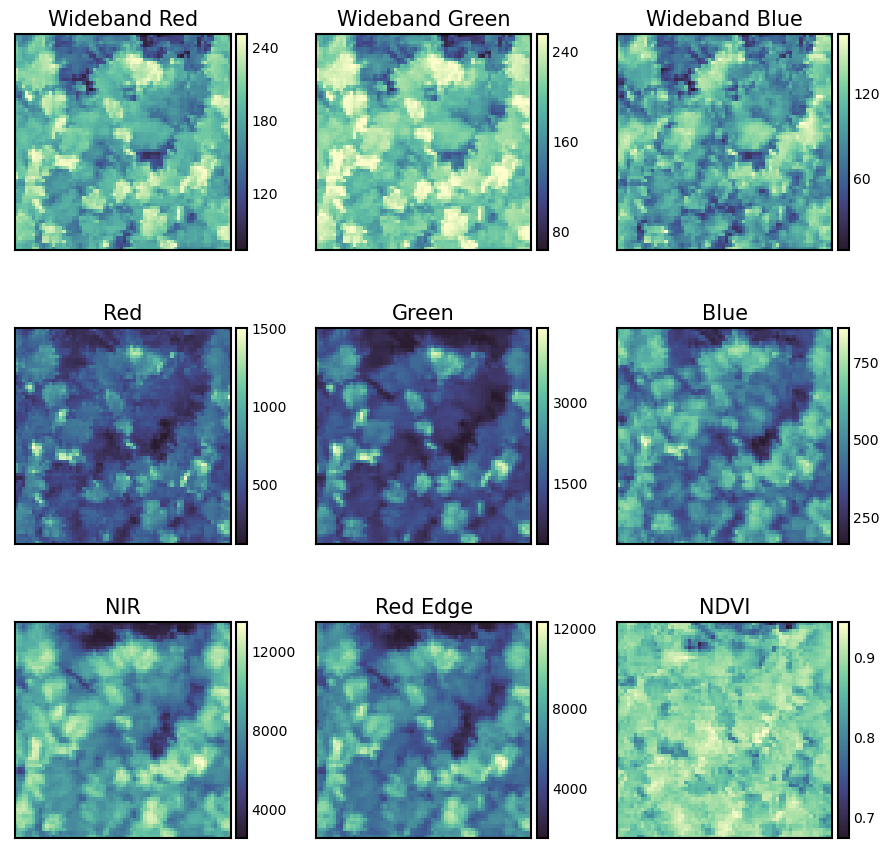

In [53]:
def crop_center(img,cropx,cropy):
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

g = isns.ImageGrid(crop_center(df.iloc[0]['itc'], 64, 64))
for ax, band in zip(g.axes.flatten(), bands):
    ax.set_title(bands_readable[band])

## Produce whitened, noised, randrotated, stretched crops

### Produce crops

In [54]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [55]:
df['crop'] = None
for idx, row in df.iterrows():
    crop = crop_center(row['itc'], 64, 64)
    crop = row['itc']
    df.at[idx, 'crop'] = [crop]
df = df.explode('crop')

In [56]:
df.columns

Index(['bc_index', '_ignore', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'itc',
       'dims', 'crop'],
      dtype='object')

In [57]:
df = df.set_index(['bc_index'])

In [58]:
df.columns

Index(['_ignore', 'name', 'y0', 'y1', 'x0', 'x1', 'src', 'itc', 'dims',
       'crop'],
      dtype='object')

#### Remove NDVI nans

In [59]:
df['crop'] = df['crop'].apply(lambda x: np.nan_to_num(x))

### Check crop

In [60]:
import seaborn_image as isns

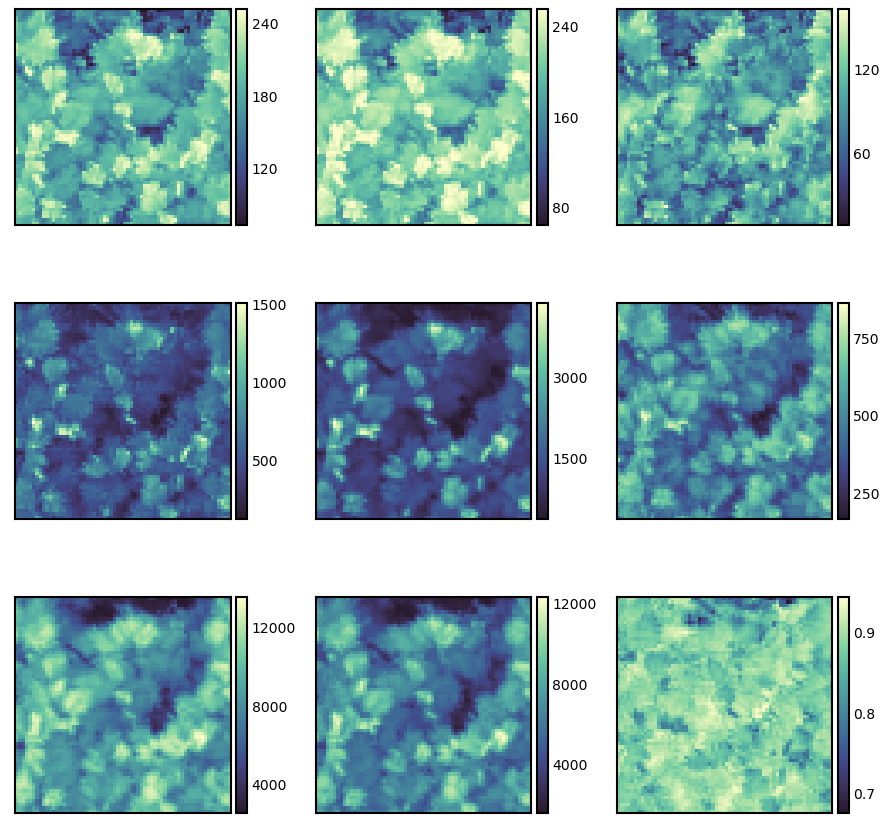

In [61]:
isns.ImageGrid(crop_center(df.loc[0, 'crop'], 64, 64))

### Check distributions of values

In [67]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
bands_readable = {
    'wr': 'Wideband Red',
    'wb': 'Wideband Blue',
    'wg': 'Wideband Green',
    'r': 'Red',
    'b': 'Blue',
    'g': 'Green',
    'nir': 'NIR',
    'red_edge': 'Red Edge',
    'ndvi': 'NDVI',
    'chm': 'CHM'
}
props = ['mean_no_glcm', 'mean', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [ ]:
band_maxes = np.asarray([max([np.nanmax(df['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_maxes))

[255.0, 255.0, 255.0, 9078.422, 8151.5425, 4525.3228, 15971.092, 15825.321, 0.98923224]


In [ ]:
band_mins = np.asarray([min([np.nanmin(df['crop'].iloc[j][:,:,i]) for j in range(len(df.index))]) for i in [*range(8), -1]])
print(list(band_mins))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3638862]


In [ ]:
print([(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[8, 8, 8, 14, 13, 13, 14, 14, 0]


In [ ]:
print([2**(math.ceil(math.log(i,2))) for i in band_maxes[[*range(8), -1]]])

[256, 256, 256, 16384, 8192, 8192, 16384, 16384, 1]


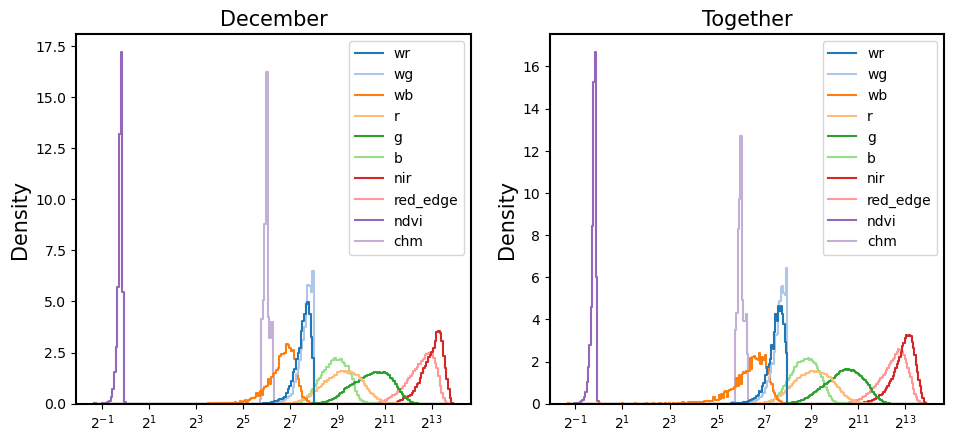

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5.6*2, 4.8))
for ax, df_, title in zip(axes, [df[df['src']=='18Dec2020'], df], ['December', 'Together']):
    sns.histplot(
        data=pd.DataFrame(
            np.stack(
                [
                    np.concatenate(
                        [
                            np.clip(crop_center(df_['crop'].iloc[j][:,:,i], 64, 64).flatten(),
                                    0.4, None)
                            for j in range(len(df_.index))
                        ]
                    )
                    for i in range(len(bands))
                ]
            ).T,
            columns=bands
        ),
        palette='tab20',
        log_scale=2,
        stat='density', common_norm=False,
        element='step', fill=False,
        ax=ax
    )
    ax.set_title(title)

### Multiple z-levels

In [54]:
z_levels = np.asarray([1, 2, 4, 8])
zl_side_px = 64 // z_levels

In [55]:
zl_u = z_levels
zl_sp_u = zl_side_px
zl_sp_u

array([64, 32, 16,  8])

In [56]:
df_nc = df_binned.copy()[['crop']]

In [57]:
z_crops = 64
for zl, zl_sp in tqdm(zip(zl_u, zl_sp_u), total=len(zl_u)):
    for i in ['x', 'y']:
        df_nc['zl_{}_corner_{}'.format(zl, i)] = None
        for idx, l in zip(df_nc.index,
                          np.random.randint(0, zl_sp+1 if zl!=1 else 1, (len(df_nc), z_crops))):
            df_nc.at[idx, 'zl_{}_corner_{}'.format(zl, i)] = l
for idx in tqdm(df_nc.index, total=len(df)):
    randxoff = np.random.randint(df_nc.at[idx, 'crop'].shape[0] - zl_sp_u[0])
    randyoff = np.random.randint(df_nc.at[idx, 'crop'].shape[1] - zl_sp_u[0])
    df_nc.at[idx, 'zl_1_corner_x'.format(zl)] += randxoff
    df_nc.at[idx, 'zl_1_corner_y'.format(zl)] += randyoff

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [58]:
df_nc = df_nc.reset_index()

In [59]:
df_nc = df_nc.explode(list(df_nc.columns[2:]), ignore_index=True)

In [60]:
df_nc = df_nc.reset_index() 

In [61]:
df_nc = df_nc.rename(columns={'index': 'zc_iter'})

In [62]:
df_nc['zc_iter'] %= z_crops

In [63]:
df_nc = df_nc.set_index(['bc_index', 'zc_iter'])

In [64]:
for zl, zl_sp in zip(zl_u, zl_sp_u):
    df_nc['zl_{}_crop'.format(zl)] = None
for idx, row in tqdm(df_nc.iterrows(), total=len(df_nc)):
    xadd, yadd = 0, 0
    for zl, zl_sp in zip(zl_u, zl_sp_u):
        c_x = row['zl_{}_corner_x'.format(zl)]
        c_y = row['zl_{}_corner_y'.format(zl)]
        df_nc.at[idx,'zl_{}_crop'.format(zl)] = row['crop'][xadd+c_x:,yadd+c_y:][:zl_sp,:zl_sp]
        xadd += c_x
        yadd += c_y

  0%|          | 0/4224 [00:00<?, ?it/s]

In [65]:
df_nc.iloc[-1,:].apply(lambda x: x[:,:,0].size if isinstance(x, np.ndarray) else float('nan'))

crop             113146.0
zl_1_corner_x         NaN
zl_1_corner_y         NaN
zl_2_corner_x         NaN
zl_2_corner_y         NaN
zl_4_corner_x         NaN
zl_4_corner_y         NaN
zl_8_corner_x         NaN
zl_8_corner_y         NaN
zl_1_crop          4096.0
zl_2_crop          1024.0
zl_4_crop           256.0
zl_8_crop            64.0
Name: (66, 63), dtype: float64

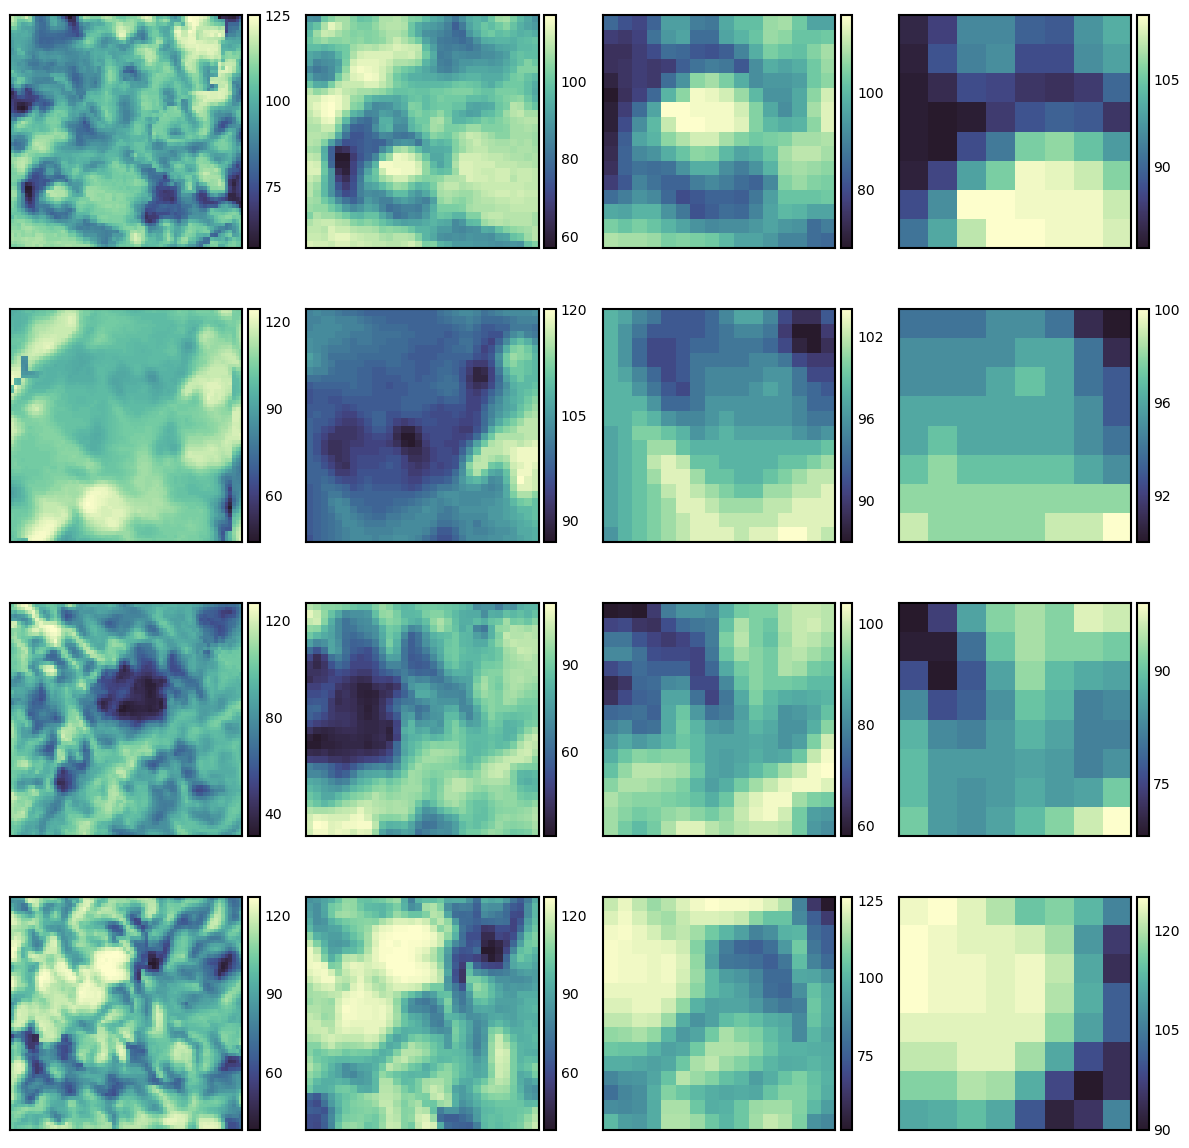

In [66]:
isns.ImageGrid([row[col][:,:,0] for idx, row in df_nc.sample(4, random_state=42).iterrows() for col in df_nc.columns if '_crop' in col], col_wrap=4)

### Noising

In [67]:
def noise_image(arr):
    noise = np.random.choice([0, 1], size=arr.shape, replace=True, p=[0.2, 0.8])
    return np.where(noise, arr, 128)

In [68]:
df_noise = pd.DataFrame(index=df_nc.index, columns=[*df_nc.columns[9:], 'n_iter'])

In [69]:
df_noise

zl_1_crop zl_2_crop zl_4_crop zl_8_crop n_iter
bc_index zc_iter                                               
0        0             NaN       NaN       NaN       NaN    NaN
         1             NaN       NaN       NaN       NaN    NaN
         2             NaN       NaN       NaN       NaN    NaN
         3             NaN       NaN       NaN       NaN    NaN
         4             NaN       NaN       NaN       NaN    NaN
...                    ...       ...       ...       ...    ...
66       59            NaN       NaN       NaN       NaN    NaN
         60            NaN       NaN       NaN       NaN    NaN
         61            NaN       NaN       NaN       NaN    NaN
         62            NaN       NaN       NaN       NaN    NaN
         63            NaN       NaN       NaN       NaN    NaN

[4224 rows x 5 columns]

In [70]:
n_crops = 1
zlevels = [1, 2, 4, 8]
for idx, row in tqdm(df_nc.iterrows(), total=len(df_nc)):
    for zl in zlevels:
        noised = []
        for i in range(n_crops):
            if zl == 1 or True:
                noised.append(noise_image(row['zl_{}_crop'.format(zl)]))
            else:
                noised.append(row['zl_{}_crop'.format(zl)])
        df_noise.at[idx, 'zl_{}_crop'.format(zl)] = noised
        df_noise.at[idx, 'n_iter'] = range(n_crops)
df_noise = df_noise.explode([*['zl_{}_crop'.format(zl) for zl in zlevels], 'n_iter'])

  0%|          | 0/4224 [00:00<?, ?it/s]

In [71]:
df_noise = df_noise.reset_index()

In [72]:
df_noise.columns

Index(['bc_index', 'zc_iter', 'zl_1_crop', 'zl_2_crop', 'zl_4_crop',
       'zl_8_crop', 'n_iter'],
      dtype='object')

In [73]:
df_noise = df_noise.set_index(['bc_index', 'zc_iter', 'n_iter'])

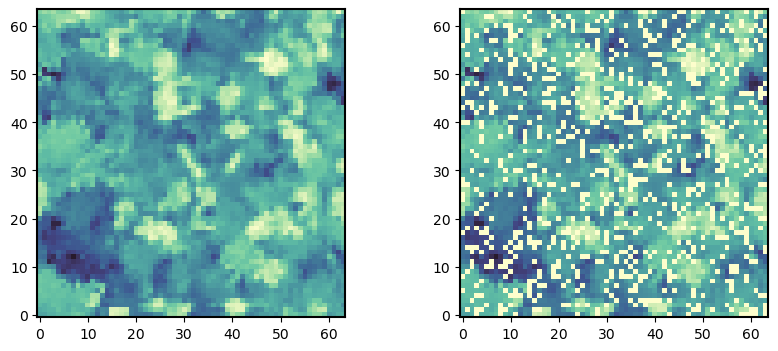

In [74]:
f, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(df_nc.iloc[12]['zl_1_crop'][:,:,0])
ax[1].imshow(df_noise.iloc[12]['zl_1_crop'][:,:,0])

In [75]:
df_noise.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4224 entries, (0, 0, 0) to (66, 63, 0)
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   zl_1_crop  4224 non-null   object
 1   zl_2_crop  4224 non-null   object
 2   zl_4_crop  4224 non-null   object
 3   zl_8_crop  4224 non-null   object
dtypes: object(4)
memory usage: 149.8+ KB


In [76]:
collectAll()

30

### Save dataframes

In [77]:
df.to_pickle('df.pickle')

In [78]:
df_nc.to_pickle('df_nc.pickle')

In [79]:
df_noise.to_pickle('df_noise.pickle')

### Reload

In [80]:
df = pd.read_pickle('df.pickle')

In [93]:
df_noise = pd.read_pickle('df_noise.pickle')

In [94]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [95]:
collectAll()

477

In [96]:
df.iloc[:,[i for i in range(len(df.columns)) if i not in [7]]].head(1)

,_ignore,name,y0,y1,x0,x1,src,dims,crop
bc_index,,,,,,,,,
0,0,Falcataria Moluccana,2310,3100,2323,2918,10May2021,"(790, 595)","[[[228.0, 242.0, 102.0, 521.6130981445312, 122..."


In [97]:
df_noise.head(1)

,,,zl_1_crop,zl_2_crop,zl_4_crop,zl_8_crop
bc_index,zc_iter,n_iter,,,,
0,0,0,"[[[94, 103, 52, 31, 128, 58, 68, 50, 88, 107],...","[[[89, 99, 47, 25, 26, 128, 51, 35, 88, 128], ...","[[[128, 128, 67, 42, 55, 84, 68, 52, 86, 106],...","[[[101, 115, 75, 28, 63, 55, 79, 66, 90, 106],..."


### Discard part

In [98]:
df_noise.index

MultiIndex([( 0,  0, 0),
            ( 0,  1, 0),
            ( 0,  2, 0),
            ( 0,  3, 0),
            ( 0,  4, 0),
            ( 0,  5, 0),
            ( 0,  6, 0),
            ( 0,  7, 0),
            ( 0,  8, 0),
            ( 0,  9, 0),
            ...
            (66, 54, 0),
            (66, 55, 0),
            (66, 56, 0),
            (66, 57, 0),
            (66, 58, 0),
            (66, 59, 0),
            (66, 60, 0),
            (66, 61, 0),
            (66, 62, 0),
            (66, 63, 0)],
           names=['bc_index', 'zc_iter', 'n_iter'], length=4224)

In [99]:
[i for i in range(100)[slice(0,4)]]

[0, 1, 2, 3]

In [100]:
df_noise = df_noise.loc[(slice(None),slice(None),slice(None)),:].copy()
collectAll()

0

In [101]:
df_noise.shape

(4224, 4)

In [102]:
df_noise.to_pickle('df_noise_smaller.pickle')

### Reload again

In [13]:
df = pd.read_pickle('df.pickle')

In [14]:
df_noise = pd.read_pickle('df_noise_smaller.pickle')

In [15]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [16]:
collectAll()

28

## Produce GLCM-property features

In [17]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [18]:
distances = [1]
angles = [0, 0.25*pi, 0.5*pi, 0.75*pi, pi, 1.25*pi, 1.5*pi, 1.75*pi]
levels = 129
symmetric = False
normed = True

def glcms_from_crop(crop):
    glcms = np.stack([graycomatrix(crop[:,:,i], distances=distances, angles=angles,
                              levels=levels, symmetric=symmetric, normed=False)
                 for i in range(8)], axis=-1)[:128,:128]
    if normed:
        return norm(glcms)
    else:
        return glcms

def norm(glcms):
    return glcms / np.sum(glcms, axis=(0,1,2,3), keepdims=True)

def graycomean(glcm):
    return np.sum(glcm.T * np.arange(glcm.shape[0]))

def graycovar(glcm, mean):
    return np.sum(glcm.T * np.square(np.arange(glcm.shape[0]) - mean)) 

props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

def graycoprops_from_glcms(glcms, crop):
    new_dict = {}
    for band in bands:
        new_dict[(band, 'mean_no_glcm')] = np.mean(crop[:,:,bands.index(band)])
        if band in ['ndvi', 'chm']:
            continue
        mean = graycomean(glcms[:,:,:,:,bands.index(band)])
        new_dict[(band, 'mean')] = mean
        new_dict[(band, 'var')] = graycovar(glcms[:,:,:,:,bands.index(band)], mean)
        for prop in props[3:]:             
            new_dict[(band, prop)] = graycoprops(glcms[:,:,:,:,bands.index(band)], prop).mean()
    return new_dict

In [19]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=5)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [20]:
for col in df_noise.columns:
    print(col)
    df_noise[col+'_props'] = df_noise.iloc[:][col].parallel_apply(lambda x: graycoprops_from_glcms(glcms_from_crop(x[:,:,:-2]), x[:,:,:]))

zl_1_crop


zl_2_crop


zl_4_crop


zl_8_crop


In [21]:
collectAll()

0

In [22]:
df_glcm = df_noise[[i for i in df_noise.columns if '_props' in i]]

In [23]:
df_glcm.to_pickle('df_glcm_intermediary.pickle')

### Fix our columns

In [24]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi', 'chm']
props = ['mean_no_glcm', 'mean', 'var', 'contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

In [25]:
df_glcm_new = pd.DataFrame(index=df_glcm.index)

In [26]:
for col in df_glcm.columns:
    df_glcm_new = pd.concat((df_glcm_new, df_glcm[col].progress_apply(pd.Series)), axis=1)
    df_glcm_new.columns = [(col, *ij) if isinstance(ij, tuple) and len(ij) == 2 else ij for ij in df_glcm_new.columns]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

  0%|          | 0/4224 [00:00<?, ?it/s]

In [27]:
df_glcm.columns

Index(['zl_1_crop_props', 'zl_2_crop_props', 'zl_4_crop_props',
       'zl_8_crop_props'],
      dtype='object')

In [28]:
df_glcm_new.columns

Index([       ('zl_1_crop_props', 'wr', 'mean_no_glcm'),
                      ('zl_1_crop_props', 'wr', 'mean'),
                       ('zl_1_crop_props', 'wr', 'var'),
                  ('zl_1_crop_props', 'wr', 'contrast'),
             ('zl_1_crop_props', 'wr', 'dissimilarity'),
               ('zl_1_crop_props', 'wr', 'homogeneity'),
                       ('zl_1_crop_props', 'wr', 'ASM'),
                    ('zl_1_crop_props', 'wr', 'energy'),
               ('zl_1_crop_props', 'wr', 'correlation'),
              ('zl_1_crop_props', 'wg', 'mean_no_glcm'),
       ...
                ('zl_8_crop_props', 'red_edge', 'mean'),
                 ('zl_8_crop_props', 'red_edge', 'var'),
            ('zl_8_crop_props', 'red_edge', 'contrast'),
       ('zl_8_crop_props', 'red_edge', 'dissimilarity'),
         ('zl_8_crop_props', 'red_edge', 'homogeneity'),
                 ('zl_8_crop_props', 'red_edge', 'ASM'),
              ('zl_8_crop_props', 'red_edge', 'energy'),
         ('zl_8_crop

### Save our GLCM props dataframe.

In [29]:
df_glcm_new.to_pickle('df_glcm3.pickle')

In [30]:
df[['name', 'src']].to_pickle('df_metadata.pickle')

### Reload

In [31]:
df_glcm = pd.read_pickle('df_glcm3.pickle')
collectAll()

18